🔁 Loading hybrid components and data...


C:\Users\kumar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded data: full=35065 rows, test=8761 rows.
🔮 Running Prophet baseline forecast on test ds range...
📐 Computing residuals on training data and preparing seed for recursive LSTM forecasting...
🔁 Performing recursive LSTM forecasting for 8761 steps...
✅ Hybrid forecast (Prophet + LSTM residual) generated.
📊 Calculating evaluation metrics...

--- Model Comparison (Test Set) ---
| Metric   |       Prophet |        Hybrid |
|:---------|--------------:|--------------:|
| MAE      |        17.690 |        16.581 |
| RMSE     |        27.608 |        25.129 |
| MAPE (%) | 172516298.312 | 370107580.779 |
🖼️ Plotting results...


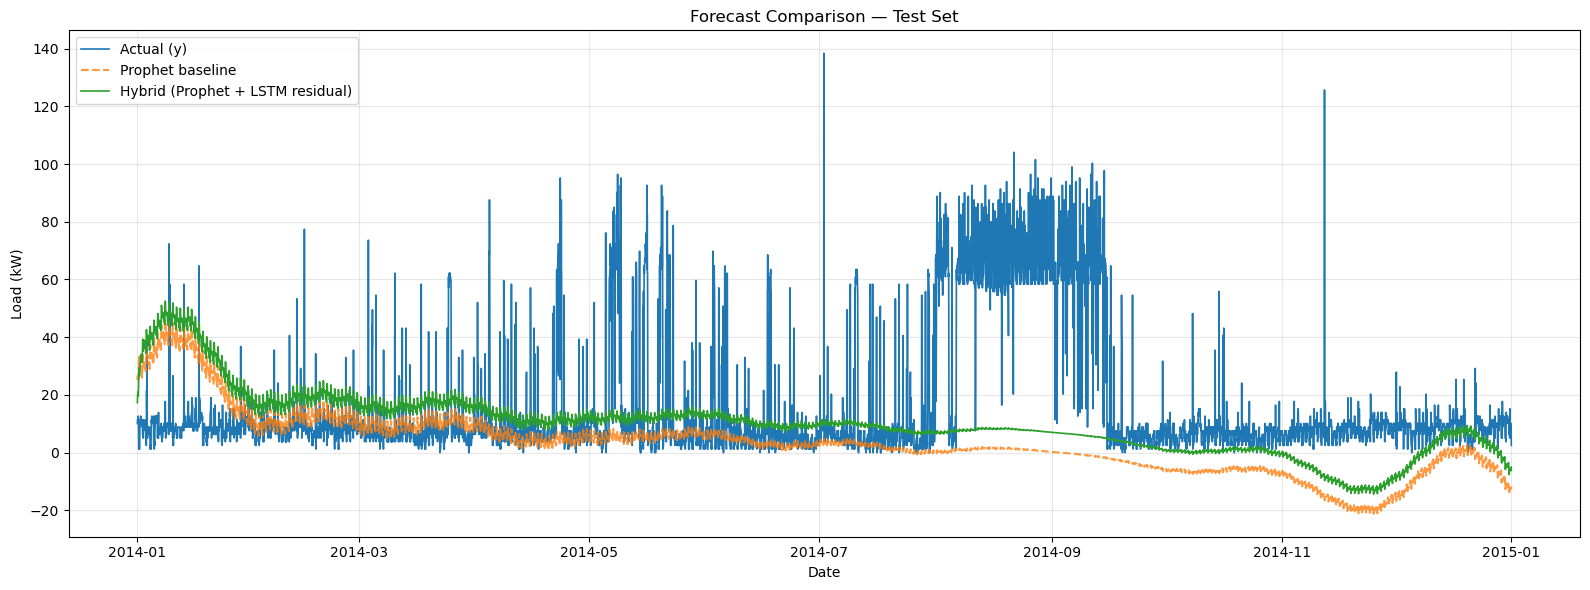

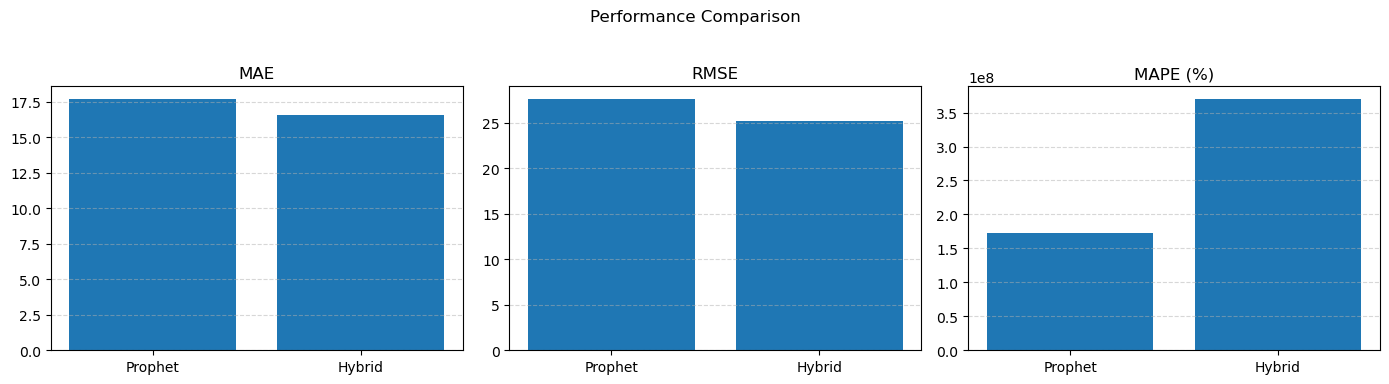

In [2]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

hybrid_model_path = '../models/hybrid_prophet_lstm_model.pkl'
data_path = '../data/industrial_load_hourly.parquet'
split_date = pd.to_datetime('2014-01-01 00:00:00')
TIME_STEPS = 168  
INPUT_FEATURES = 1

use_shap = False

def safe_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)
    denom = np.clip(np.abs(y_true), 1e-8, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

if not os.path.exists(hybrid_model_path):
    raise FileNotFoundError(f"Model file not found at: {hybrid_model_path}")

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at: {data_path}")

print(" Loading hybrid components and data...")
hybrid_components = joblib.load(hybrid_model_path)

expected_keys = ['prophet_model', 'residual_lstm', 'residual_scaler']
missing = [k for k in expected_keys if k not in hybrid_components]
if missing:
    raise KeyError(f"Missing components from model bundle: {missing}. "
                   "Make sure you saved prophet_model, residual_lstm, residual_scaler.")

m_prophet = hybrid_components['prophet_model']
m_lstm = hybrid_components['residual_lstm']
residual_scaler = hybrid_components['residual_scaler']

df_full = pd.read_parquet(data_path).reset_index().rename(columns={'timestamp': 'ds', 'load': 'y'})
df_full['ds'] = pd.to_datetime(df_full['ds'])
df_test = df_full[df_full['ds'] >= split_date].copy().reset_index(drop=True)

if df_test.empty:
    raise ValueError(f"No test rows found on/after split_date={split_date}")

print(f" Loaded data: full={len(df_full)} rows, test={len(df_test)} rows.")

print(" Running Prophet baseline forecast on test ds range...")
future = df_test[['ds']].copy()
prophet_pred_df = m_prophet.predict(future)
if 'yhat' not in prophet_pred_df.columns:
    raise KeyError("Prophet predict output missing 'yhat' column.")
df_test['yhat_prophet'] = prophet_pred_df['yhat'].values
y_prophet = df_test['yhat_prophet'].values
y_true = df_test['y'].values

print(" Computing residuals on training data and preparing seed for recursive LSTM forecasting...")
df_train = df_full[df_full['ds'] < split_date].copy().reset_index(drop=True)
if df_train.empty:
    raise ValueError("Training data is empty. Ensure split_date is set correctly and training data exists.")

prophet_train_pred = m_prophet.predict(df_train[['ds']])
if 'yhat' not in prophet_train_pred.columns:
    raise KeyError("Prophet training prediction missing 'yhat' column.")
df_train['yhat_prophet'] = prophet_train_pred['yhat'].values
df_train['residual'] = df_train['y'] - df_train['yhat_prophet']

try:
    scaled_train_residuals = residual_scaler.transform(df_train[['residual']]).reshape(-1)
except Exception as e:
    raise RuntimeError(f"Failed to apply residual_scaler.transform on training residuals: {e}")

if len(scaled_train_residuals) < TIME_STEPS:
    raise ValueError(f"Not enough training residuals to form a seed of length TIME_STEPS={TIME_STEPS}. "
                     f"Have {len(scaled_train_residuals)} training residuals.")

seed_scaled = scaled_train_residuals[-TIME_STEPS:].astype(np.float32)

current_batch = seed_scaled.reshape(1, TIME_STEPS, INPUT_FEATURES)

num_test_steps = len(df_test)
print(f" Performing recursive LSTM forecasting for {num_test_steps} steps...")

pred_scaled_list = []
for i in range(num_test_steps):
    # m_lstm.predict returns shape (1, 1) or (1,) depending on model; normalize to scalar
    pred_scaled = m_lstm.predict(current_batch, verbose=0)
    # handle possible shapes
    pred_val = np.array(pred_scaled).ravel()[0]
    pred_scaled_list.append(pred_val)
    # append prediction and slide window
    # new shape for appended value: (1, 1, 1)
    new_val = np.array(pred_val, dtype=np.float32).reshape(1, 1, 1)
    current_batch = np.concatenate([current_batch[:, 1:, :], new_val], axis=1)

pred_scaled_array = np.array(pred_scaled_list).reshape(-1, 1)  # shape (num_test_steps, 1)

try:
    predicted_residuals = residual_scaler.inverse_transform(pred_scaled_array).reshape(-1)
except Exception as e:
    raise RuntimeError(f"Failed to inverse_transform predicted residuals: {e}")

df_test['residual_lstm'] = predicted_residuals
df_test['yhat_hybrid'] = df_test['yhat_prophet'] + df_test['residual_lstm']
y_hybrid = df_test['yhat_hybrid'].values

print(" Hybrid forecast (Prophet + LSTM residual) generated.")

print(" Calculating evaluation metrics...")
prophet_metrics = calculate_metrics(y_true, y_prophet)
hybrid_metrics = calculate_metrics(y_true, y_hybrid)

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'Prophet': [prophet_metrics['MAE'], prophet_metrics['RMSE'], prophet_metrics['MAPE']],
    'Hybrid': [hybrid_metrics['MAE'], hybrid_metrics['RMSE'], hybrid_metrics['MAPE']],
}).set_index('Metric')

print("\n--- Model Comparison (Test Set) ---")
print(metrics_df.to_markdown(floatfmt=".3f"))

print("🖼️ Plotting results...")

plt.figure(figsize=(16, 6))
plt.plot(df_test['ds'], y_true, label='Actual (y)', linewidth=1.2)
plt.plot(df_test['ds'], y_prophet, label='Prophet baseline', linestyle='--', alpha=0.8)
plt.plot(df_test['ds'], y_hybrid, label='Hybrid (Prophet + LSTM residual)', linewidth=1.2)
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.title('Forecast Comparison — Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
metrics = ['MAE', 'RMSE', 'MAPE (%)']
for ax, metric in zip(axes.flatten(), metrics):
    values = [metrics_df.loc[metric, 'Prophet'], metrics_df.loc[metric, 'Hybrid']]
    ax.bar(['Prophet','Hybrid'], values)
    ax.set_title(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.suptitle("Performance Comparison")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if use_shap:
    try:
        import shap
        print("🧠 Generating SHAP values with DeepExplainer (works for TF/Keras models)...")
        scaled_vals = scaled_train_residuals.astype(np.float32)
        X_bg = []
        for i in range(len(scaled_vals) - TIME_STEPS):
            X_bg.append(scaled_vals[i:i+TIME_STEPS])
            if len(X_bg) >= 200:  # limit
                break
        X_bg = np.array(X_bg)[:50]  
        X_bg = X_bg.reshape(-1, TIME_STEPS, INPUT_FEATURES)

        explainer = shap.DeepExplainer(m_lstm, X_bg)
        
        full_sequence = np.concatenate([seed_scaled, pred_scaled_array.ravel().astype(np.float32)])
        X_test_windows = []
        for i in range(len(full_sequence) - TIME_STEPS + 1):
            X_test_windows.append(full_sequence[i:i+TIME_STEPS])
            if len(X_test_windows) >= 200:
                break
        X_test_windows = np.array(X_test_windows)[:100].reshape(-1, TIME_STEPS, INPUT_FEATURES)
        shap_values = explainer.shap_values(X_test_windows)
        print(" SHAP values computed. Use shap.summary_plot / shap.dependence_plot to visualize.")
    except Exception as e:
        print(f" SHAP failed or is not installed/compatible: {e}")
        print("If you want SHAP, install shap and enable use_shap=True. Prefer DeepExplainer for Keras models.")
